# Quantum Computing Math Cheat Sheet

In [59]:
import numpy as np
import sympy as sym
from IPython.display import display, Math
import random
import matplotlib.pyplot as plt

In [60]:
sym.init_printing() # prety printing of math

## Subjects
- Complex numbers
- Complex numbers - Polar Form   
- Complex conjugate    
- Magnitude     
- Conjugate transpose   
- Inner product   
- Eucledian norm
- Unit vector
- Distance between vectors
- Orthonormal bases
- Computational (standard) basis

In [61]:
# AngleAnnotation class
# from:
# https://matplotlib.org/stable/gallery/text_labels_and_annotations/angle_annotation.html#angleannotation-class

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.transforms import IdentityTransform, TransformedBbox, Bbox


class AngleAnnotation(Arc):
    """
    Draws an arc between two vectors which appears circular in display space.
    """
    def __init__(self, xy, p1, p2, size=75, unit="points", ax=None,
                 text="", textposition="inside", text_kw=None, **kwargs):
        """
        Parameters
        ----------
        xy, p1, p2 : tuple or array of two floats
            Center position and two points. Angle annotation is drawn between
            the two vectors connecting *p1* and *p2* with *xy*, respectively.
            Units are data coordinates.

        size : float
            Diameter of the angle annotation in units specified by *unit*.

        unit : str
            One of the following strings to specify the unit of *size*:

            * "pixels": pixels
            * "points": points, use points instead of pixels to not have a
              dependence on the DPI
            * "axes width", "axes height": relative units of Axes width, height
            * "axes min", "axes max": minimum or maximum of relative Axes
              width, height

        ax : `matplotlib.axes.Axes`
            The Axes to add the angle annotation to.

        text : str
            The text to mark the angle with.

        textposition : {"inside", "outside", "edge"}
            Whether to show the text in- or outside the arc. "edge" can be used
            for custom positions anchored at the arc's edge.

        text_kw : dict
            Dictionary of arguments passed to the Annotation.

        **kwargs
            Further parameters are passed to `matplotlib.patches.Arc`. Use this
            to specify, color, linewidth etc. of the arc.

        """
        self.ax = ax or plt.gca()
        self._xydata = xy  # in data coordinates
        self.vec1 = p1
        self.vec2 = p2
        self.size = size
        self.unit = unit
        self.textposition = textposition

        super().__init__(self._xydata, size, size, angle=0.0,
                         theta1=self.theta1, theta2=self.theta2, **kwargs)

        self.set_transform(IdentityTransform())
        self.ax.add_patch(self)

        self.kw = dict(ha="center", va="center",
                       xycoords=IdentityTransform(),
                       xytext=(0, 0), textcoords="offset points",
                       annotation_clip=True)
        self.kw.update(text_kw or {})
        self.text = ax.annotate(text, xy=self._center, **self.kw)

    def get_size(self):
        factor = 1.
        if self.unit == "points":
            factor = self.ax.figure.dpi / 72.
        elif self.unit[:4] == "axes":
            b = TransformedBbox(Bbox.unit(), self.ax.transAxes)
            dic = {"max": max(b.width, b.height),
                   "min": min(b.width, b.height),
                   "width": b.width, "height": b.height}
            factor = dic[self.unit[5:]]
        return self.size * factor

    def set_size(self, size):
        self.size = size

    def get_center_in_pixels(self):
        """return center in pixels"""
        return self.ax.transData.transform(self._xydata)

    def set_center(self, xy):
        """set center in data coordinates"""
        self._xydata = xy

    def get_theta(self, vec):
        vec_in_pixels = self.ax.transData.transform(vec) - self._center
        return np.rad2deg(np.arctan2(vec_in_pixels[1], vec_in_pixels[0]))

    def get_theta1(self):
        return self.get_theta(self.vec1)

    def get_theta2(self):
        return self.get_theta(self.vec2)

    def set_theta(self, angle):
        pass

    # Redefine attributes of the Arc to always give values in pixel space
    _center = property(get_center_in_pixels, set_center)
    theta1 = property(get_theta1, set_theta)
    theta2 = property(get_theta2, set_theta)
    width = property(get_size, set_size)
    height = property(get_size, set_size)

    # The following two methods are needed to update the text position.
    def draw(self, renderer):
        self.update_text()
        super().draw(renderer)

    def update_text(self):
        c = self._center
        s = self.get_size()
        angle_span = (self.theta2 - self.theta1) % 360
        angle = np.deg2rad(self.theta1 + angle_span / 2)
        r = s / 2
        if self.textposition == "inside":
            r = s / np.interp(angle_span, [60, 90, 135, 180],
                                          [3.3, 3.5, 3.8, 4])
        self.text.xy = c + r * np.array([np.cos(angle), np.sin(angle)])
        if self.textposition == "outside":
            def R90(a, r, w, h):
                if a < np.arctan(h/2/(r+w/2)):
                    return np.sqrt((r+w/2)**2 + (np.tan(a)*(r+w/2))**2)
                else:
                    c = np.sqrt((w/2)**2+(h/2)**2)
                    T = np.arcsin(c * np.cos(np.pi/2 - a + np.arcsin(h/2/c))/r)
                    xy = r * np.array([np.cos(a + T), np.sin(a + T)])
                    xy += np.array([w/2, h/2])
                    return np.sqrt(np.sum(xy**2))

            def R(a, r, w, h):
                aa = (a % (np.pi/4))*((a % (np.pi/2)) <= np.pi/4) + \
                     (np.pi/4 - (a % (np.pi/4)))*((a % (np.pi/2)) >= np.pi/4)
                return R90(aa, r, *[w, h][::int(np.sign(np.cos(2*a)))])

            bbox = self.text.get_window_extent()
            X = R(angle, r, bbox.width, bbox.height)
            trans = self.ax.figure.dpi_scale_trans.inverted()
            offs = trans.transform(((X-s/2), 0))[0] * 72
            self.text.set_position([offs*np.cos(angle), offs*np.sin(angle)])

In [100]:
# Complex plane
# from:
# https://github.com/osnove/other/blob/master/complex_plane.py
# with a few changes by me

import matplotlib.pyplot as plt
import numpy as np # dodamo še numerično knjižico 
get_ipython().run_line_magic('matplotlib', 'inline')


def complex_plane2(z,p1=None,p2=None,angle_size=0,center=(0,0),axis_type=0, angle_position="edge"):
    """Creates complex plane and shows complex numbers as vectors (complexors)
    
    Parameters
    ----------
    z : array of complex values
        array of complex values to be shown
    axis_type : int 
        three types of shapes of complex plane:
        0 : symple
        1 : with grid
        2 : moved axis to middle 
    -----------------------------------
    # Example
    z=[20+10j,15,-10-10j,5+15j]
    complex_plane2(z,2) """

    w=max(np.abs(z))
    fig, ax = plt.subplots()
        
    if axis_type==0: 
        plt.axis("off")
        plt.text(-0.15*w, 0.8*w, "i", fontsize=14)
        plt.text( 0.8*w,-0.15*w, "ℝ", fontsize=14)
    elif axis_type==1: 
        plt.axis("on")
        plt.grid()
        plt.text(-0.15*w, 0.8*w, "i", fontsize=14)
        plt.text( 0.8*w,-0.15*w, 'ℝ', fontsize=14)
    else:
         # Move left y-axis and bottim x-axis to centre, passing through (0,0)
        ax.spines['left'].set_position('center')
        ax.spines['bottom'].set_position('center')

        # Eliminate upper and right axes
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        # Show ticks in the left and lower axes only
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')

        # ax.set_xlabel('                                                 ℝ')
        # ax.set_ylabel('                                                 i')
        plt.text(-0.15*w, 0.8*w, "i", fontsize=14)
        plt.text( 0.8*w,-0.15*w, 'ℝ', fontsize=14)

    plt.xlim(-w,w)
    plt.ylim(-w,w)
    plt.arrow(0, -w, 0, 1.9*w, head_width=w/20, head_length=w/20, fc='k', ec='k');
    plt.arrow(-w, 0, 1.9*w, 0, head_width=w/20, head_length=w/20, fc='k', ec='k');

    for i in range(len(z)):
        fi_a=np.angle(z[i])
        x=z[i].real -abs(w)/20*np.cos(fi_a)
        y=z[i].imag-abs(w)/20*np.sin(fi_a)
        plt.arrow(0, 0, x, y, head_width=w/20, head_length=w/20, fc='b', ec='b');
        
              
        # call AngleAnnotation func
        if p2 != None or p1 != None:
            point, = ax.plot(*center, marker="o")
            AngleAnnotation(center, p1[1], p2[1], ax=ax, size=angle_size, text=r"$\theta$", textposition=angle_position)
        

### Complex numbers

In [63]:
display( Math('a,b \\in \\mathbb{R}') )
display( Math('c \\in \\mathbb{C}') )
display( Math('i := \\sqrt{-1}') )
display( Math('c = a + i \\cdot b') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Complex numbers - Polar Form

In [64]:
display( Math('r,\\theta \\in \\mathbb{R}') )
display( Math('c \\in \\mathbb{C}') )
display( Math('c = re^{i\\theta}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

#### Geometric interpretation

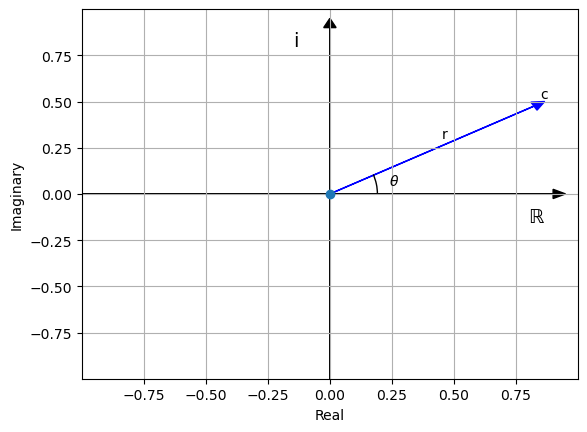

In [65]:
import matplotlib.pyplot as plt
import numpy as np # dodamo še numerično knjižico 
get_ipython().run_line_magic('matplotlib', 'inline')

# params for complex_plane2 func
z=[0.866+0.5j] # 𝜃 = 30

# params for AngleAnnotation func
center = (0, 0)
p1 = [(0, 0), (0, 0)]
p2 = [(0, 0), (0.3, 0.18)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.45,0.3,'r')
plt.text(0.85,0.52,'c')
plt.show()

In [66]:
display( Math('r,\\theta \\in \\mathbb{R}') )
display( Math('r = 1') )
display( Math("\\text{Euler's formula: } e^{i\\theta} = cos \\theta + i \\cdot sin \\theta") )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [67]:
display( Math('c = r \\cdot cos \\theta + r \\cdot i \\cdot sin \\theta = r(cos \\theta + i \\cdot sin \\theta)') )
display( Math('c = re^{i\\theta}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Samples

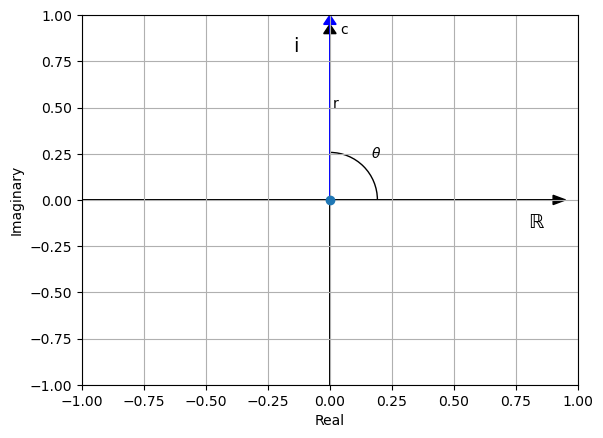

In [68]:
z=[0+1j] # 𝜃 = 𝜋/2

center = (0, 0)
p1 = [(0, 0), (30, 0)]
p2 = [(0, 0), (0, 30)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.01,0.5,'r')
plt.text(0.04,0.9,'c')
plt.show()

In [69]:
display( Math('e^{i \\cdot \\frac {\\pi}{2}} = i') )

<IPython.core.display.Math object>

In [70]:
display( Math('r = 1') )
display( Math('\\theta = \\frac {\\pi}{2}') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\frac {\\pi}{2}} = 1 \\cdot i = i = 0 + i \\cdot 1') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

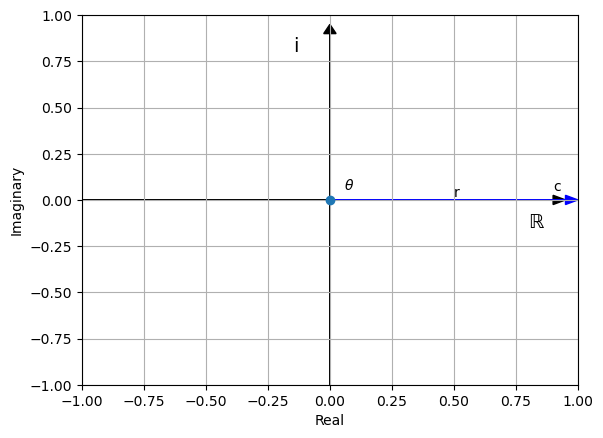

In [71]:
z=[1+0j]  # 𝜃 = 0

center = (0, 0)
p1 = [(0, 0), (1, 1)]
p2 = [(0, 0), (1, 1)]
angle_size= 35

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.5,0.02,'r')
plt.text(0.9,0.05,'c')
plt.show()

In [72]:
display( Math('r = 1') )
display( Math('\\theta = 0') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot 0} = 1 \\cdot 1 = 1 = 1 + i \\cdot 0') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

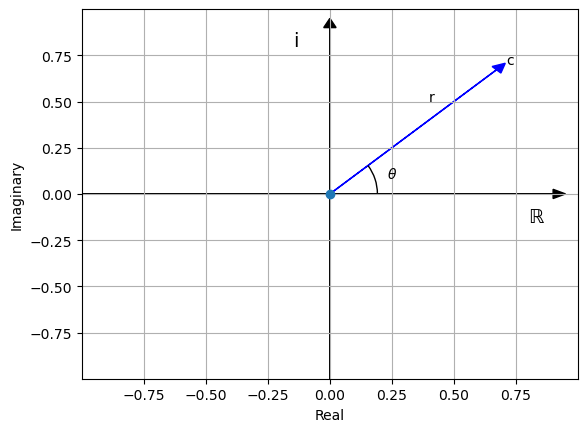

In [73]:
z=[0.7071 + 0.7071j] # 𝜃 = 𝜋/4

# params for AngleAnnotation func
center = (0, 0)
p1 = [(0, 0), (1.0, 0)]
p2 = [(0, 0), (1.0, 1.0)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.4,0.5,'r')
plt.text(0.71,0.70,'c')
plt.show()

In [74]:
display( Math('r = 1') )
display( Math('\\theta = \\frac {\\pi}{4}') )
display( Math('c = 𝑟(𝑐𝑜𝑠\\theta + 𝑖⋅sin\\theta) = 1(\\frac{\\sqrt{2}}{2} + i⋅\\frac{\\sqrt{2}}{2}) = 0.7071 + i⋅0.7071') )
display( Math('\\text{Validate using Pythagorean theorem:  } c = \\sqrt{a^2 + b^2 }') )
display( Math('r = \\sqrt{ (r \\cdot 𝑐𝑜𝑠\\theta)^2 + (r \\cdot sin\\theta)^2} = (1 \\cdot \\frac{\\sqrt{2}}{2})^2 + (1 \\cdot \\frac{\\sqrt{2}}{2})^2 = \
             \\frac{1}{2} + \\frac{1}{2} = 1' ) )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [75]:
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\frac {\\pi}{4}} = e^{i \\cdot \\frac {\\pi}{4}} = 0.7071 + i⋅0.7071') )

<IPython.core.display.Math object>

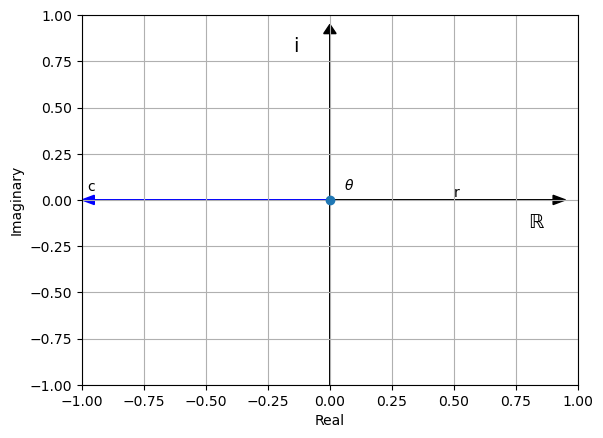

In [76]:
z=[-1+0j]  # 𝜃 = 𝜋

center = (0, 0)
p1 = [(0, 0), (1, 1)]
p2 = [(0, 0), (1, 1)]
angle_size= 35

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.5,0.02,'r')
plt.text(-0.98,0.05,'c')
plt.show()

In [77]:
display( Math('e^{i \\cdot \\pi} = -1') )

<IPython.core.display.Math object>

In [78]:
display( Math('r = 1') )
display( Math('\\theta = \\pi') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\pi} = 1 \\cdot -1 = -1 = -1 + i \\cdot 0') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

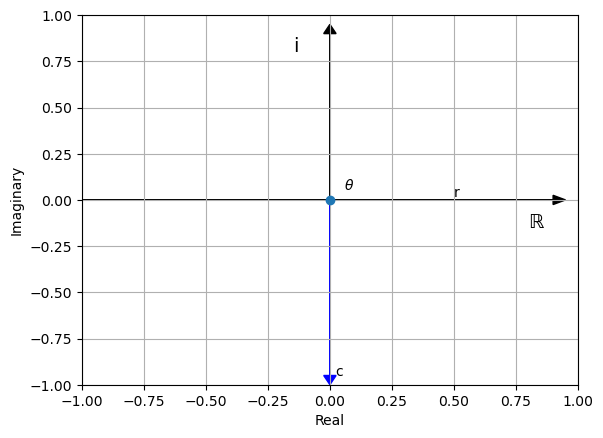

In [79]:
z=[0+ (-1j)]  # 𝜃 = 3𝜋/2

center = (0, 0)
p1 = [(0, 0), (1, 1)]
p2 = [(0, 0), (1, 1)]
angle_size= 35

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.5,0.02,'r')
plt.text(0.02,-0.95,'c')
plt.show()

In [80]:
display( Math('𝑐𝑜𝑠(3\\frac{\\pi}{2}) = 0') )
display( Math('sin(3\\frac{\\pi}{2}) = -1') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [81]:
display( Math('e^{i \\cdot \\frac {3 \\cdot \\pi}{2}} = 𝑐𝑜𝑠(3\\frac{\\pi}{2}) + i \\cdot sin(3\\frac{\\pi}{2}) = 0 + i\\cdot(-1) = -i') )

<IPython.core.display.Math object>

In [82]:
display( Math('r = 1') )
display( Math('\\theta = \\frac {3 \\cdot \\pi}{2}') )
display( Math('c = re^{i\\theta} = 1 \\cdot e^{i \\cdot \\frac {3 \\cdot \\pi}{2}} = 1 \\cdot -i = -i = 0 + i \\cdot -1') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Complex conjugate

In [83]:
display( Math('a,b \\in \\mathbb{R}') )
display( Math('c \\in \\mathbb{C}') )
display( Math('c = a+i \\cdot b') )
display( Math('c^* = a-i \\cdot b') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [84]:
display( Math('c = re^{i\\theta}') )
display( Math('c^* = re^{-i\\theta}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Magnitude of a complex number

In [85]:
display( Math('\\text{Magnitude of a real number: }') )
display( Math('r \\in \\mathbb{R} \\rightarrow |r| \\in \\mathbb{R^+}') )
display( Math('|r| = \\sqrt{r^2}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Magnitude should be a Real non-negative number.

In [86]:
display( Math('\\text{Magnitude of a complex number: }') )
display( Math('c \\in \\mathbb{C} \\rightarrow |c| \\in \\mathbb{R^+}') )
display( Math('|c| = \\sqrt{c \\cdot c^*}') )
display( Math('|c|^2 = c \\cdot c^*') )
display( Math('c \\cdot c^* = (a + i \\cdot b)(a - i \\cdot b) = a - i^2 \\cdot b^2 = a^2 + b^2 \\rightarrow \\: \\in \\mathbb{R} \\text{ non-negative}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

##### Example:

In [87]:
display( Math('c = 3 + 4i') )
display( Math('|c| = \\sqrt{(3+4i)(3-4i)} = \\sqrt{9-12i + 12i - 16i^2} = \\sqrt{9 - (16i^2)} = \\sqrt{9 - (-16)} = \\sqrt{25} = 5') )
display( Math('|c|^2 = c \\cdot c^* = 25') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

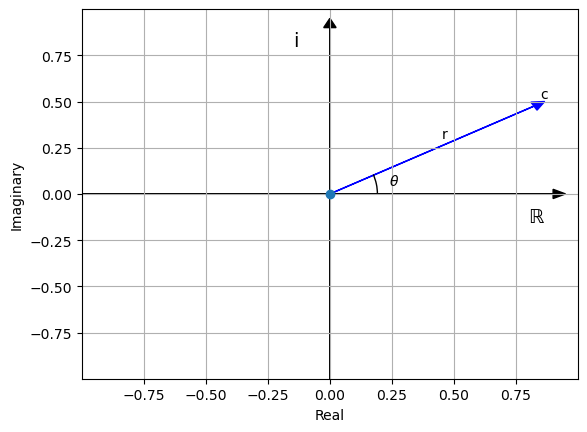

In [88]:
import matplotlib.pyplot as plt
import numpy as np # dodamo še numerično knjižico 
get_ipython().run_line_magic('matplotlib', 'inline')

# params for complex_plane2 func
z=[0.866+0.5j] # 𝜃 = 30

# params for AngleAnnotation func
center = (0, 0)
p1 = [(0, 0), (0, 0)]
p2 = [(0, 0), (0.3, 0.18)]
angle_size= 95

complex_plane2(z,p1,p2,angle_size,center,axis_type=1,angle_position="edge")
        
plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.text(0.45,0.3,'r')
plt.text(0.85,0.52,'c')
plt.show()

The magnitude of a vector *c* is *r* which is the length of the *c* vector.

In [89]:
display( Math('|c| = \\sqrt{c \\cdot c^*}') )
display( Math('c = re^{i\\theta}') )
display( Math('c^* = re^{-i\\theta}') )
display( Math('|c| = |re^{i\\theta}| = \\sqrt{re^{i\\theta} \\cdot re^{-i\\theta}} = \
\\sqrt{r^2e^{i(\\theta - \\theta)}} = \\sqrt{r^2e^{i \\cdot 0}} = \\sqrt{r^2} = |r|') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Braket notation

In [90]:
display( Math('| \\psi \\rangle \\: , \\: \langle \\psi |') )

<IPython.core.display.Math object>

In [91]:
v= np.array(['𝜓_1','𝜓_2','𝜓_3','𝜓_d'])
display( Math('| \\psi \\rangle \\text{  - ket is a column vector } ') )
v.shape = (4,1)
display( Math('| \\psi \\rangle = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [92]:
display( Math('\langle \\psi | \\text{  - bra is a row vector } ') )
v.shape = (1,4)
display( Math('\langle \\psi | = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Conjugate Transpose

In [93]:
v= np.array(['𝜓_1','𝜓_2','𝜓_3','𝜓_d'])
v.shape = (4,1)
display( Math('| \\psi \\rangle = ' + sym.latex(sym.sympify(v)) + '\\in \\mathbb{C^d}') )

v_ct= np.array(['𝜓_1^*','𝜓_2^*','𝜓_3^*','𝜓_d^*'])
display( Math('(| \\psi \\rangle ^*)^T = \langle \\psi | = [𝜓_1^* \\; 𝜓_2^* \\; 𝜓_3^* \\; 𝜓_4^* \\: ... \\: 𝜓_d^*] ' + sym.latex(sym.sympify(v)) ))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Complex conjugate of the vector's entries

### Inner product
#### How similar two vectors are
An inner product of two vectors is the overlap between the two vectors (the projection of one onto the other).

In [94]:
v_theta= np.array(['𝜃_1','𝜃_2','𝜃_3','𝜃_d'])
v_theta.shape = (4,1)
display( Math('\langle \\psi | \\theta \\rangle = \sum_{i=1}^{d} (\\psi_i^*) \\theta_i = [𝜓_1^* \\; 𝜓_2^* \\; 𝜓_3^* \\; 𝜓_4^* \\: ... \\: 𝜓_d^*] '\
              + sym.latex(sym.sympify(v_theta)) + ' = c \\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

In [95]:
display( Math('\langle \\psi | \\theta \\rangle = \langle \\theta | \\psi \\rangle^* = c \\in \\mathbb{C^d}') )

<IPython.core.display.Math object>

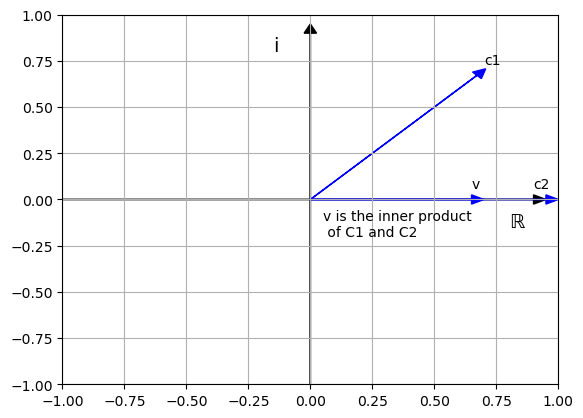

In [186]:
z2=[1+0j,0.7071 + 0.7071j, 0.7 + 0.0j] # 0, 𝜋/4
complex_plane2(z2, axis_type=1)

plt.text(0.7,0.73,'c1')
plt.text(0.9,0.06,'c2')
plt.text(0.65,0.06,'v')
plt.text(0.05,-0.2,'v is the inner product \n of C1 and C2')
plt.show()

### Euclidean norm
#### Length of a vector
The overlap of a vector with itself, a non negative real number.

In [218]:
display( Math('\\text{As we computed the length of a complex number: }|c| = \\sqrt{c \\cdot c^*}') )

<IPython.core.display.Math object>

In [219]:
display( Math('|| \\: | \\psi \\rangle \\: ||_2 = \\sqrt {\langle \\psi | \\psi \\rangle}') )

<IPython.core.display.Math object>

In [231]:
print('\nExample using a unit vector:\nAn inner product of a vector with itself (the overlap with itself).')
print('The norm (length) of a unit vector is 1.\n')
display( Math('\\frac {1}{\\sqrt{2}} \\text{ is a normalization factor}') )
v3= np.array([1,'i'])
v4= np.array([1,'-i'])

v3.shape = (2,1)
v4.shape = (1,2)

display( Math('| \\psi \\rangle = \\frac {1}{\\sqrt{2}}' + sym.latex(sym.sympify(v3)) + '\\in \\mathbb{C^2}') )
display( Math('\\langle \\psi | = (| \\psi \\rangle^*)^T = \\frac {1}{\\sqrt{2}}' + sym.latex(sym.sympify(v4)) + '\\in \\mathbb{C^2}') )

display( Math('|| \\: | \\psi \\rangle \\: ||_2 = \\sqrt {\langle \\psi | \\psi \\rangle} = \
\\sqrt {\\frac {1}{\\sqrt{2}}(' + sym.latex(sym.sympify(v4)) + ') \\frac {1}{\\sqrt{2}}(' + sym.latex(sym.sympify(v3)) + ')} \
 = \\frac {1}{\\sqrt{2}} \\sqrt{1 + (-i)i} = \\frac {1}{\\sqrt{2}} \\sqrt{1 + (-(-1)} = \\frac {1}{\\sqrt{2}} \\sqrt{2} = 1') )


Example using a unit vector:
An inner product of a vector with itself (the overlap with itself).
The norm (length) of a unit vector is 1.



<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Distance using Euclidean norm

39:50

# ==========================================================

In [11]:
display( Math('Symbolic \\: variables: \\: \\textit{x, xi, y}') )

<IPython.core.display.Math object>

In [111]:
display( Math('Prime \\: number: %i , \\: with \\: %i \\: bits' %(p, p.bit_length())) )

NameError: name 'p' is not defined

In [124]:
display( Math('k^{-1}k \cong 1(mod \\enspace p-1)') )

<IPython.core.display.Math object>

In [126]:
def display_users_keys():
    global users
    
    display( Math('gcd(k,p-1)=1') )
    display( Math('k^{-1}k(mod \\enspace p-1)') )
    display( Math('k^{-1}k(mod \\enspace p-1) \\cong 1(mod \\enspace p-1)') )

    for user in users.keys():
        k= users[user]['k']
        ki= users[user]['ki']

        display( Math('%s \\: k= %i , \\: with \: %i \: bits' %(user, k, k.bit_length())) )
        display( Math('%s \\: k^{-1}= %i , \: with \: %i \: bits' %(user, ki, ki.bit_length())) )

In [128]:
display( Math('k1 \cong ks^{ka}(mod \\enspace p)') )

<IPython.core.display.Math object>

In [130]:
display( Math('k2 \cong k1^{kb}(mod \\enspace p)') )

<IPython.core.display.Math object>

In [131]:
# k2= k1^kb(mod p)

def bob_get_k2(k1:int) -> int:
    global users, p
    
    k2= pow(k1,users['Bob']['k'],p)

    display( Math('\\text {Bob sends k2 to Alice.}') )
    display( Math('k2= %i , \\: with \: %i \: bits' %(k2, k2.bit_length())) )
    
    return k2

### 7. Alice sends *k3 $\cong$ k2<sup>ka<sup>-1</sup></sup>(mod p)* to Bob.

In [132]:
display( Math('k3 \cong k2^{ka^{-1}}(mod \\enspace p)') )

<IPython.core.display.Math object>

In [133]:
# k3= k2^(ka^-1)(mod p)

def alice_get_k3(k2:int) -> int:
    global users, p
    
    k3= pow(k2,users['Alice']['ki'],p)

    display( Math('\\text {Alice sends k3 to Bob.}') )
    display( Math('k3= %i , \\: with \: %i \: bits' %(k3, k3.bit_length())) )
    
    return k3

### 8. Bob computes *ks'= k3<sup>kb<sup>-1</sup></sup>(mod p)*.

In [134]:
display( Math("ks' \cong k3^{kb^{-1}}(mod \\enspace p)") )

<IPython.core.display.Math object>

In [142]:

secret_msg= "a secret message from Alice"
display( Math('\\text{Alice original message: } \\text{"%s"}' %secret_msg))

# 1. Decide on numbers bits length: 2^bits-length
set_globals(_bits_length=129,_p=0)

# 2. Everyone agree on a public key: p, and publish it
generate_prime()

# 3. Each user selects a random number k that is a coprime to p-1 and its modular multiplicative inverse k-1
generate_k_for_users()
generate_k_inverse_for_users()

# 4. Alise chooses a shared-secret-key ks to be shared with Bob
alice_generate_shared_secret()
display( Math("\\text{Alice's shared secret = } %i , \\: with \: %i \: bits" %(users['Alice']['ks'], users['Alice']['ks'].bit_length())) )

# 5. Alice encrypts a message using the shared secret
alice_msg_cipher= get_alice_encrypted_message(msg_data=secret_msg, shared_secret=users['Alice']['ks'])
display( Math('\\text{Alice message cipher: } %s %s' %(str(alice_msg_cipher)[:20], ". . .")) )

# 6. Alice sends k1= kska(mod p) to Bob.
k1= alice_get_k1()

# 7. Bob sends k2= k1kb(mod p) to Alice.
k2= bob_get_k2(k1)

# 8. Alice sends k3= k2ka-1(mod p) to Bob.
k3= alice_get_k3(k2)

# 9. Bob computes kb= k3kb-1(mod p).
bob_compute_shared_secret(k3)
display( Math('\\text{Bob computes the shared secret.}') )
display( Math("\\text{Bob's shared secret = } %i , \\: with \: %i \: bits" %(users['Bob']['ks'], users['Bob']['ks'].bit_length())) )

# 10. verify: assert(alice_ks == bob_ks)
if verify_shared_keys_indentical() == True:
    display( Math("\\text{Secret shared keys are identical!}") )
    
# 11. Bob decrypts alice's encrypted message using the shared secret key he computed
decrypted_msg= get_decrypted_cleartext_message(msg_ciphertext_data=alice_msg_cipher, shared_secret=users['Bob']['ks'])

# 12. verify that the original and received messages are identical
display( Math("\\text{Alice's decrypted message by Bob: } \\text{'%s'}" %str(decrypted_msg)[2:-1]))
if verify_messages_indentical(secret_msg,decrypted_msg) == True:
    display(Math("\\text{The original and decrypted messages are identical!}") )


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>